In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import sklearn
from sklearn.decomposition import TruncatedSVD

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [3]:
import pandas as pd

# Assuming your DataFrame is named 'product_ratings'
def get_product_row(df, product_id):
   
    product_row = df[df['item_id'] == product_id]
    
    return product_row



In [4]:
epsilon = 0.1  # Set your epsilon value here
product_ratings = pd.read_json('renttherunway_final_data.json', lines=True)
product_descriptions = product_ratings.dropna()
ratings_utility_matrix = product_descriptions.pivot_table(values='rating', index='user_id', columns='item_id', fill_value=0)

In [5]:
product_descriptions.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"
5,fit,734848,32b,364092,138lbs,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,"5' 8""",8,45.0,"April 30, 2016"


In [6]:
item_category_avg_rating = product_ratings.groupby(['item_id', 'category'])['rating'].mean().reset_index()

# Optionally, reset the index to make the DataFrame more manageable
item_category_avg_rating.reset_index(drop=True, inplace=True)

# Display the first few rows of the DataFrame
item_category_avg_rating = item_category_avg_rating.sort_values(by='rating', ascending=False)
print(item_category_avg_rating)

      item_id  category  rating
2084  1128155     dress    10.0
4395  2259054      coat    10.0
4405  2263480       top    10.0
5481  2788643  jumpsuit    10.0
4406  2263613       top    10.0
...       ...       ...     ...
5270  2680432   sweater     4.0
4163  2139139    jacket     4.0
4440  2279989     skirt     4.0
5172  2632929   sweater     4.0
4698  2403738       top     2.0

[5855 rows x 3 columns]


In [7]:
items_list = product_ratings['item_id'].unique()
num_items = len(items_list)
print(num_items)

5850


In [27]:
import random
import time
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

class EpsilonGreedyRecommender:
    def __init__(self, epsilon, ratings_matrix, product_descriptions, items_list):
        self.epsilon = epsilon
        self.ratings_matrix = ratings_matrix
        self.product_descriptions = product_descriptions
        self.num_users, self.num_items = ratings_matrix.shape
        self.vectorizer = TfidfVectorizer(stop_words='english')
        self.X1 = self.vectorizer.fit_transform(product_descriptions["review_text"])
        self.model = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=1)
        self.model.fit(self.X1)
        self.terms = self.vectorizer.get_feature_names_out()
        self.items_list = items_list
    
    def epsilon_greedy_recommendation(self, user_id, num_recommendations=10):
        random.seed(time.time())
        random_number = random.random()
        if random_number < self.epsilon:
            return self.explore_recommendations(num_recommendations)
        else:
            return self.exploit_recommendations(user_id, num_recommendations)
    
    def explore_recommendations(self, num_recommendations):
        random_indices = np.random.choice(range(self.num_items), num_recommendations, replace=False)
        random_items = [self.items_list[i] for i in random_indices]
        return random_items
    
    def exploit_recommendations(self, user_id, num_recommendations):
        user_product_id = np.argmax(self.ratings_matrix.loc[user_id])
        cluster_id = self.predict_cluster(user_product_id)
        return self.get_cluster_recommendations(cluster_id, num_recommendations)
    
    def predict_cluster(self, product_id):
        Y = self.vectorizer.transform([self.product_descriptions.iloc[product_id]["review_text"]])
        prediction = self.model.predict(Y)
        return prediction[0]
    
    def get_cluster_recommendations(self, cluster_id, num_recommendations):
        order_centroids = self.model.cluster_centers_.argsort()[:, ::-1]
        cluster_terms = order_centroids[cluster_id]
        recommendations = []
        for term in cluster_terms:
            product_indices = self.get_products_with_term(term)
            recommendations.extend(product_indices)
            if len(recommendations) >= num_recommendations:
                break
        return recommendations[:num_recommendations]
    
    def get_products_with_term(self, term_index):
        products_with_term = []
        for product_id, product_description in enumerate(self.product_descriptions["review_text"]):
            if self.terms[term_index] in product_description:
                products_with_term.append(self.items_list[product_id])
        return products_with_term

In [29]:
recommender = EpsilonGreedyRecommender(epsilon, ratings_utility_matrix, product_descriptions,items_list)

In [30]:
user_id = 420272
num_recommendations = 5

# Get recommendations for the user using epsilon-greedy strategy
recommended_items = recommender.epsilon_greedy_recommendation(user_id, num_recommendations)
print("Recommended items:", recommended_items)

Recommended items: [2047325, 2562266, 2159129, 2714854, 2154123]


In [31]:
product_ratings['user_id'].unique().shape

(105571,)

In [32]:
product_ratings['item_id'].unique().shape

(5850,)

In [33]:
product_descriptions.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"
5,fit,734848,32b,364092,138lbs,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,"5' 8""",8,45.0,"April 30, 2016"


In [34]:
user_id = 420272

In [35]:
ratings_df = product_ratings[['user_id', 'item_id', 'rating']].copy()

# Display the first few rows of the ratings DataFrame
print(ratings_df.head())

   user_id  item_id  rating
0   420272  2260466    10.0
1   273551   153475    10.0
2   360448  1063761    10.0
3   909926   126335     8.0
4   151944   616682    10.0


In [36]:
# print(user_item_counts)
user_item_ratings_counts = ratings_df.groupby(['user_id', 'item_id']).agg({'rating': ['sum', 'count']}).reset_index()
user_item_ratings_counts.columns = ['user_id', 'item_id', 'total_rating', 'count']

# Display the first few rows of the DataFrame
# print(user_item_ratings_counts.head())
user_item_dict = {}
for index, row in user_item_ratings_counts.iterrows():
    user_id = row['user_id']
    item_id = row['item_id']
    total_rating = row['total_rating']
    count = row['count']
    if user_id not in user_item_dict:
        user_item_dict[user_id] = {}
    user_item_dict[user_id][item_id] = {'total_rating': total_rating, 'count': count}

user_appearances = product_ratings['user_id'].value_counts().reset_index()
user_appearances.columns = ['user_id', 'time_step']
user_appearances_dict = user_appearances.set_index('user_id')['time_step'].to_dict()
# print(user_appearances_dict)


In [37]:
import pandas as pd

# Assuming you have a DataFrame named 'product_ratings' containing your dataset
user_item_ratings_counts = product_ratings.groupby(['user_id', 'category']).agg({'rating': ['sum', 'count']}).reset_index()
user_item_ratings_counts.columns = ['user_id', 'category', 'total_rating', 'count']

# Creating user_category_dict
user_category_dict = {}
for index, row in user_item_ratings_counts.iterrows():
    user_id = row['user_id']
    category = row['category']
    total_rating = row['total_rating']
    count = row['count']
    if user_id not in user_category_dict:
        user_category_dict[user_id] = {}
    user_category_dict[user_id][category] = {'total_rating': total_rating, 'count': count}
    
user_appearances = product_ratings['user_id'].value_counts().reset_index()
user_appearances.columns = ['user_id', 'time_step']
user_appearances_dict = user_appearances.set_index('user_id')['time_step'].to_dict()

In [38]:
# print(user_category_dict)

In [39]:
categories_list = product_descriptions['category'].unique()
num_categories= len(categories_list)

In [40]:
import numpy as np

class UCBRecommender:

    def __init__(self, category_list, user_category_dict, time_step_dict,item_category_avg):
        self.category_list = category_list
        self.user_category_dict = user_category_dict
        self.time_step_dict = time_step_dict
        self.total_rewards = {}
        for user_id, category_dict in user_category_dict.items():
            self.total_rewards[user_id] = sum(category['total_rating'] for category in category_dict.values())
        self.item_category_avg = item_category_avg

    def get_top_ucb_categories(self, user_id,n_top = 2):
        ucb_values = {} 
        for category_id in self.category_list:
            if category_id in self.user_category_dict[user_id]:  # Check if the user has pulled this category
                num_pulls_category = self.user_category_dict[user_id][category_id]['count']
            else:
                
                num_pulls_category = 0
            ucb_values[category_id] = self.total_rewards[user_id] / (num_pulls_category + 1e-6) + np.sqrt(2 * np.log(self.time_step_dict[user_id]) / (num_pulls_category + 1e-6))
        sorted_ucb_values = sorted(ucb_values.items(), key=lambda x: x[1], reverse=True)
        top_n_ucb_categories = [category_id for category_id, _ in sorted_ucb_values[:n_top]]
        return top_n_ucb_categories

    def update(self, user_id, category_id, reward):
        if user_id not in self.user_category_dict:
            self.user_category_dict[user_id] = {}
        if category_id not in self.user_category_dict[user_id]:
            self.user_category_dict[user_id][category_id] = {'total_rating': 0, 'count': 0}
        self.user_category_dict[user_id][category_id]['total_rating'] += reward
        self.total_rewards[user_id] += reward
        self.user_category_dict[user_id][category_id]['count'] += 1
        self.time_step_dict[user_id] += 1
    def get_top_n_recommendations(self,user_id,num_recommendations =9,n_top = 2):
        top_n_categories = self.get_top_ucb_categories(user_id,n_top)
        each_n = num_recommendations/n_top
        remainder_n = num_recommendations - (each_n*n_top)
        recommendations = []
        each_0 = each_n + remainder_n
        for i in range(n_top):
            if i == 0:
                top_each_n_items = self.item_category_avg[self.item_category_avg['category'] == top_n_categories[i]]['item_id'].value_counts().head(int(each_0))
                top_each_n_items = top_each_n_items.index.tolist()
            else :
                top_each_n_items = self.item_category_avg[self.item_category_avg['category'] == top_n_categories[i]]['item_id'].value_counts().head(int(each_n))
                top_each_n_items = top_each_n_items.index.tolist()
            recommendations += top_each_n_items
        return recommendations  
    


In [41]:
UCB = UCBRecommender(categories_list,user_category_dict,user_appearances_dict,item_category_avg_rating)
user_id = 13028
recommendations=UCB.get_top_n_recommendations(user_id,10)
print(recommendations)

[2827079, 2496394, 2036606, 2771965, 2049439, 497011, 1729232, 486225, 141688, 375444]


UPDATE

In [42]:
category_id = str(item_category_avg_rating[item_category_avg_rating['item_id'] == recommendations[0] ]['category'].iloc[0])
reward = 10
UCB.update(user_id,category_id,reward)
recommendations=UCB.get_top_n_recommendations(user_id,10)
print(recommendations)

[497011, 1729232, 486225, 141688, 375444, 1105210, 1132917, 1774617, 1187659, 1769705]


# Thompson sampling

In [43]:
def user_interaction(article,like_probabilities):
    click_probability = like_probabilities[article]
    reward = np.random.binomial(1, click_probability)
    return reward

In [44]:

categories = ['gown','dress','top','sheath']
number_of_categories = len(categories)
alpha=np.ones(number_of_categories)
beta=np.ones(number_of_categories)
probability_1=[]
probability_2=[]
probability_3=[]
probability_4=[]
visited_category1=[]
visited_category2=[]
rewards=[]
z=0
while z<1000:
    high_prob=-1
    for i in range(number_of_categories):
        prob = np.random.beta(alpha[i],beta[i])
        if prob>high_prob:
            high_prob=prob
            category=i
    
    random_item = product_descriptions[product_descriptions['category'] == categories[i]].sample(n = 1)
    if z>100:
        visited_category2.append(category)
        user_buy=user_interaction(category,[0.2, 0.2, 0.3, 0.75])
    else:
        visited_category1.append(category)
        user_buy=user_interaction(category,[0.8, 0.75, 0.2, 0.1])
    if not user_buy:
        rewards.append(-1)
    else:
        rewards.append(1)
    
    alpha[category]+=user_buy
    beta[category]+=(1-user_buy)
    z+=1
    probability_1.append(alpha[0]/(alpha[0]+beta[0]))
    probability_2.append(alpha[1]/(alpha[1]+beta[1]))
    probability_3.append(alpha[2]/(alpha[2]+beta[2]))
    probability_4.append(alpha[3]/(alpha[3]+beta[3]))

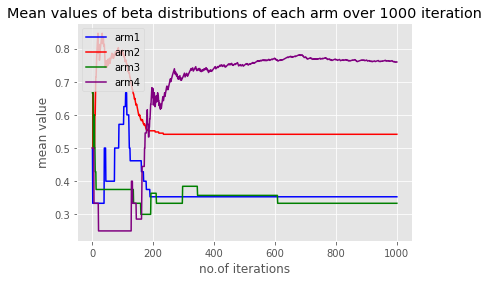

In [45]:

# Generate some example data for four lines
x = np.linspace(1, 1000, 1000)
y1 = probability_1
y2 = probability_2
y3 = probability_3
y4 = probability_4

# Create a figure and axes for the plot
fig, ax = plt.subplots()

# Plot each line with a different color and label
ax.plot(x, y1, label='arm1', color='blue')
ax.plot(x, y2, label='arm2', color='red')
ax.plot(x, y3, label='arm3', color='green')
ax.plot(x, y4, label='arm4', color='purple')

# Add a legend to the plot
ax.legend()

# Add axis labels and a title to the plot
ax.set_xlabel('no.of iterations')
ax.set_ylabel('mean value')
ax.set_title('Mean values of beta distributions of each arm over 1000 iteration')
# Show the plot
plt.show()
